# Collecting and Condensing COVID Data (Version 2)

This Jupyter notebook reads in the data from a variety of online sources that we need for the COVID Data Vizualization Project.  Some attempts are made to produce simpler to work with output files.  Depending on how long this notebook takes
to execute, it may not make sense to 'condense' the data first.

**Verion 2 Release Note**: This version of the Notebook moved the routines for retrieving and processing data to a local python library.  This allowed re-use of those functions in generating test data.  I confirmed output was IDENTICAL to the Version 1 output before 'deprecating' version 1 to a renamed file.

- **A Note about FIPS:** Some of the data includes FIPS codes (a standard geographic identifier) which should ease the process of cross-matching of data.  Clay County is 27027 and Cass County is 38017.  Minnesota is 27, North Dakota is 38.

In [1]:
# This forces a reload of any external library file if it changes.  
# Useful when developing external libraries since otherwise Jupyter 
# will not re-import any library without restarting the python kernel.

%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import git
import pickle

# Import COVID data retrieval routines from external python library
import COVIDlib.collectors as COVIDdata

In [3]:
# Mark the start of processing
start = time.perf_counter()

## Define variables of interest below
data_dir = 'our_data/'    # Data directory for files we created

## Define FIPS corresponding to various local areas
ClayFIPS = 27027
CassFIPS = 38017
MNFIPS = 27
NDFIPS = 38

## Check if data directory exists, if not, create it
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

##  John Hopkins Cases Data (FIPS Present)
    - https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

This dataset is part of COVID-19 Pandemic Novel Corona Virus (COVID-19)
epidemiological data since 22 January 2020. The JHU CCSE maintains the data on the 2019 Novel
Coronavirus COVID-19 (2019-nCoV) Data Repository on Github
(https://github.com/CSSEGISandData/COVID-19). 
I have also folded in US Census Bureau population informationf for these counties/states.

### Notes about the dataframes:
- County level daily confirmed/deaths/recovered data files changes format
  several times before April 23, 2020, so I didn't include that data. 
- State level daily data files contain some additional data that county level
  files do not contain, notably Incident_Rate, People_Tested,
  People_Hospitalized, Mortality_Rate, Testing_Rate, and Hospitalization_Rate. 
  However, it only exists starting April 12, 2020.
- Time-series data files contain more limited data (only confirmed cases and
  deaths) and are essentially redundant data compared to the daily files, so
  combining the daily files makes sense.

**Suggested Citations**: the COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University.  Population data from U.S. Census Bureau, Population Division (Release Date: March 2020)

In [4]:
## 
## Retrieve the US Census data and then John Hopkins data
##

# Retrieve needed Census Bureau data first
(cnty_pop_df, state_pop_df) = COVIDdata.retrieve_census_population_data()

# Retrieve John Hopkins data
(ts_us_confirmed_df, ts_us_dead_df, combined_cnty_df, combined_state_df) = COVIDdata.retrieve_John_Hopkins_data(cnty_pop_df, state_pop_df)

#
# Save the county and state-level processed daily dataframes into CSV files
#
combined_datafile = data_dir + "countylevel_combinedCDR.csv"
print(" - John Hopkins county level data exported to ", combined_datafile)
combined_cnty_df.to_csv(combined_datafile, index=False)

combined_datafile = data_dir + "statelevel_combinedCDR.csv"
print(" - John Hopkins state level data exported to ", combined_datafile)
combined_state_df.to_csv(combined_datafile, index=False)

#
# Save the same data to pickle files
#
combined_datafile = data_dir + "countylevel_combinedCDR.p"
print(" - John Hopkins county level data also exported to ", combined_datafile)
with open(combined_datafile, 'wb') as pickle_file:
    pickle.dump(combined_cnty_df, pickle_file)
    pickle_file.close()

combined_datafile = data_dir + "statelevel_combinedCDR.p"
print(" - John Hopkins state level data also exported to ", combined_datafile)
with open(combined_datafile, 'wb') as pickle_file:
    pickle.dump(combined_state_df, pickle_file)
    pickle_file.close()

 - John Hopkins county level data exported to  our_data/countylevel_combinedCDR.csv
 - John Hopkins state level data exported to  our_data/statelevel_combinedCDR.csv
 - John Hopkins county level data also exported to  our_data/countylevel_combinedCDR.p
 - John Hopkins state level data also exported to  our_data/statelevel_combinedCDR.p


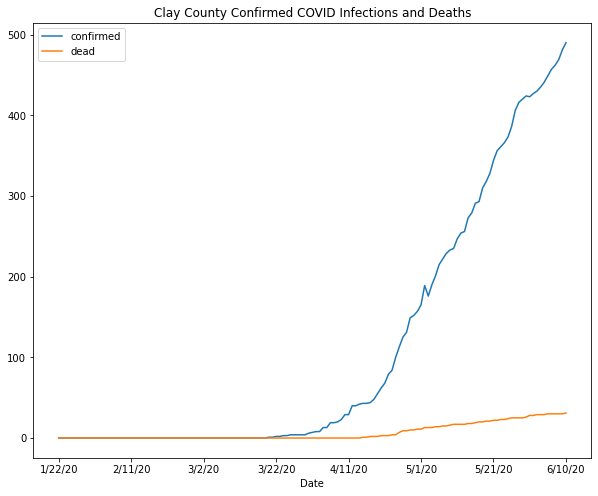

In [5]:
##
## Plot the time series datafiles to experiment with them.  These only contain Deaths and Confirmed cases,
## so I suspect we won't keep them, since I build the same data from the daily data files simultaneously retrieved from
## John Hopkins.
##

# We could transpose the dataframe to allow easier extraction of time series data on a per county level
tmp_df = ts_us_confirmed_df[ (ts_us_confirmed_df['Province_State'] == 'Minnesota') & (ts_us_confirmed_df['Admin2'] == 'Clay') ].T
tmp_df.rename(columns={ tmp_df.columns[0]: "confirmed" }, inplace = True)
confirmed_clay = tmp_df[tmp_df.index.str.match('[0-9]*/[0-9]*/[0-9]*')]  # Use pattern matching to find real dates and include

tmp_df = ts_us_dead_df[ (ts_us_confirmed_df['Province_State'] == 'Minnesota') & (ts_us_confirmed_df['Admin2'] == 'Clay') ].T
tmp_df.rename(columns={ tmp_df.columns[0]: "dead" }, inplace = True)
dead_clay = tmp_df[tmp_df.index.str.match('[0-9]*/[0-9]*/[0-9]*')] # Use pattern matching to find real dates and include

# Merge the confirmed ill and dead into one dataframe (would like recovered too, but that's not in
# these times series files).  
merged_clay = confirmed_clay.merge(dead_clay, left_index=True, right_index=True)
plot = merged_clay.plot(figsize=(10,8))
xlabel = plt.xlabel('Date')
ylabel = plt.title('Confirmed COVID Infections and Deaths')
title = plt.title('Clay County Confirmed COVID Infections and Deaths')

# NOTE: This is using PANDAS to do the plotting, it will be a lot more flexible to extra data from Pandas and then
# use matplotlib to make the plots.  For one thing, we could add labels to the plot more easily.

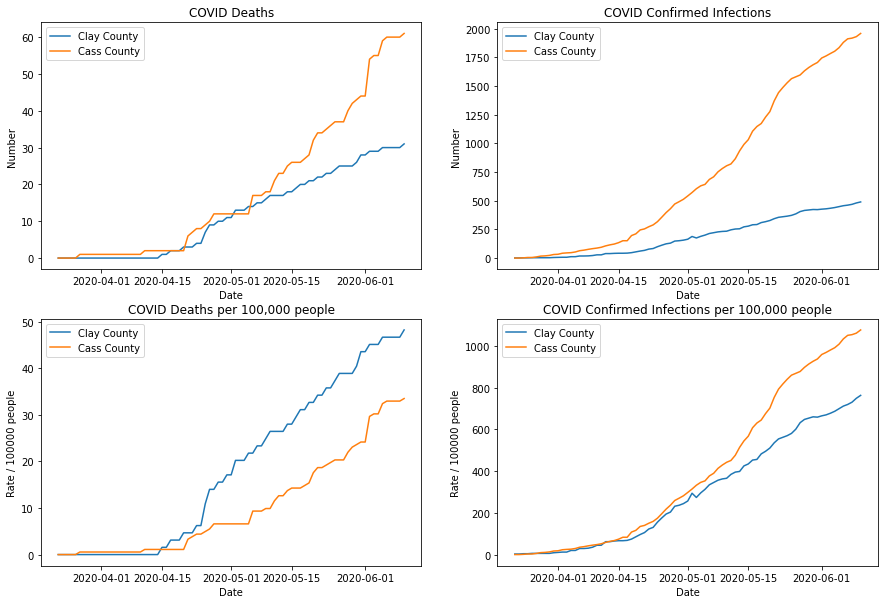

In [6]:
# Show demonstrations of plotting this data here by producing plots of data for Cass and Clay counties and North Dakota and Minnesota

#
# I will pull the data to plot into numpy arrays (notice I have to use [0] because it comes out at list of lists even for single row)
#

# County-level data for plotting
dates_cty = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['Dates'].to_list()[0], dtype='datetime64')
clay_deaths = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['Deaths'].to_list()[0],dtype='int')
clay_death_rate = (clay_deaths/combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['PopEst2019'].values)*100000
cass_deaths = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['Deaths'].to_list()[0],dtype='int')
cass_death_rate = (cass_deaths/combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['PopEst2019'].values)*100000
clay_confirmed = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['Confirmed'].to_list()[0],dtype='int')
clay_confirmed_rate = (clay_confirmed/combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['PopEst2019'].values)*100000
cass_confirmed = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['Confirmed'].to_list()[0],dtype='int')
cass_confirmed_rate = (cass_confirmed/combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['PopEst2019'].values)*100000

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Plot up deaths and death rates as plots 0 and 1
this_axs = axs[0, 0]  # Row 0, column 0
this_axs.plot(dates_cty, clay_deaths, label='Clay County')
this_axs.plot(dates_cty, cass_deaths, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Number")
title = this_axs.set_title("COVID Deaths")

this_axs = axs[1, 0]  # Row 1, column 0
this_axs.plot(dates_cty, clay_death_rate, label='Clay County')
this_axs.plot(dates_cty, cass_death_rate, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Rate / 100000 people")
title = this_axs.set_title("COVID Deaths per 100,000 people")

# Plot up confirmed infections and infection rates as plots 2 and 3
this_axs = axs[0, 1]  # Row 0, column 1
this_axs.plot(dates_cty, clay_confirmed, label='Clay County')
this_axs.plot(dates_cty, cass_confirmed, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Number")
title = this_axs.set_title("COVID Confirmed Infections")

this_axs = axs[1, 1]  # Row 1, column 1
this_axs.plot(dates_cty, clay_confirmed_rate, label='Clay County')
this_axs.plot(dates_cty, cass_confirmed_rate, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Rate / 100000 people")
title = this_axs.set_title("COVID Confirmed Infections per 100,000 people")

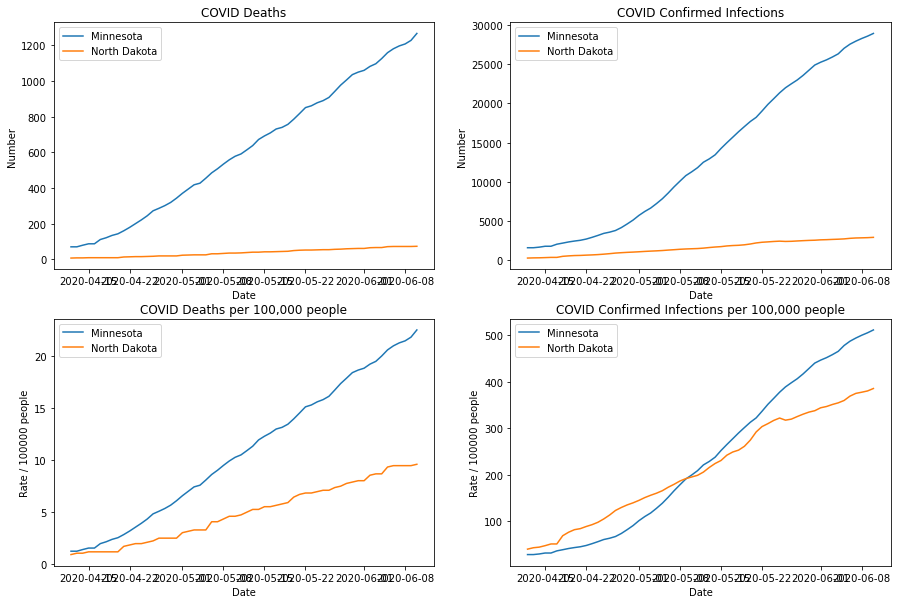

In [7]:
#
# I will pull the data to plot into numpy arrays (notice I have to use [0] because it comes out at list of lists even for single row)
#

# State-level data for plotting
dates_state = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['Dates'].to_list()[0], dtype='datetime64')
MN_deaths = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['Deaths'].to_list()[0],dtype='int')
MN_death_rate = (MN_deaths/combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['PopEst2019'].values)*100000
ND_deaths = np.array(combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['Deaths'].to_list()[0],dtype='int')
ND_death_rate = (ND_deaths/combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['PopEst2019'].values)*100000
MN_confirmed = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['Confirmed'].to_list()[0],dtype='int')
MN_confirmed_rate = (MN_confirmed/combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['PopEst2019'].values)*100000
ND_confirmed = np.array(combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['Confirmed'].to_list()[0],dtype='int')
ND_confirmed_rate = (ND_confirmed/combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['PopEst2019'].values)*100000

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Plot up deaths and death rates as plots 0 and 1
this_axs = axs[0, 0]  # Row 0, column 0
this_axs.plot(dates_state, MN_deaths, label='Minnesota')
this_axs.plot(dates_state, ND_deaths, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Number")
title = this_axs.set_title("COVID Deaths")

this_axs = axs[1, 0]  # Row 1, column 0
this_axs.plot(dates_state, MN_death_rate, label='Minnesota')
this_axs.plot(dates_state, ND_death_rate, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Rate / 100000 people")
title = this_axs.set_title("COVID Deaths per 100,000 people")

# Plot up confirmed infections and infection rates as plots 2 and 3
this_axs = axs[0, 1]  # Row 0, column 1
this_axs.plot(dates_state, MN_confirmed, label='Minnesota')
this_axs.plot(dates_state, ND_confirmed, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Number")
title = this_axs.set_title("COVID Confirmed Infections")

this_axs = axs[1, 1]  # Row 1, column 1
this_axs.plot(dates_state, MN_confirmed_rate, label='Minnesota')
this_axs.plot(dates_state, ND_confirmed_rate, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Rate / 100000 people")
title = this_axs.set_title("COVID Confirmed Infections per 100,000 people")

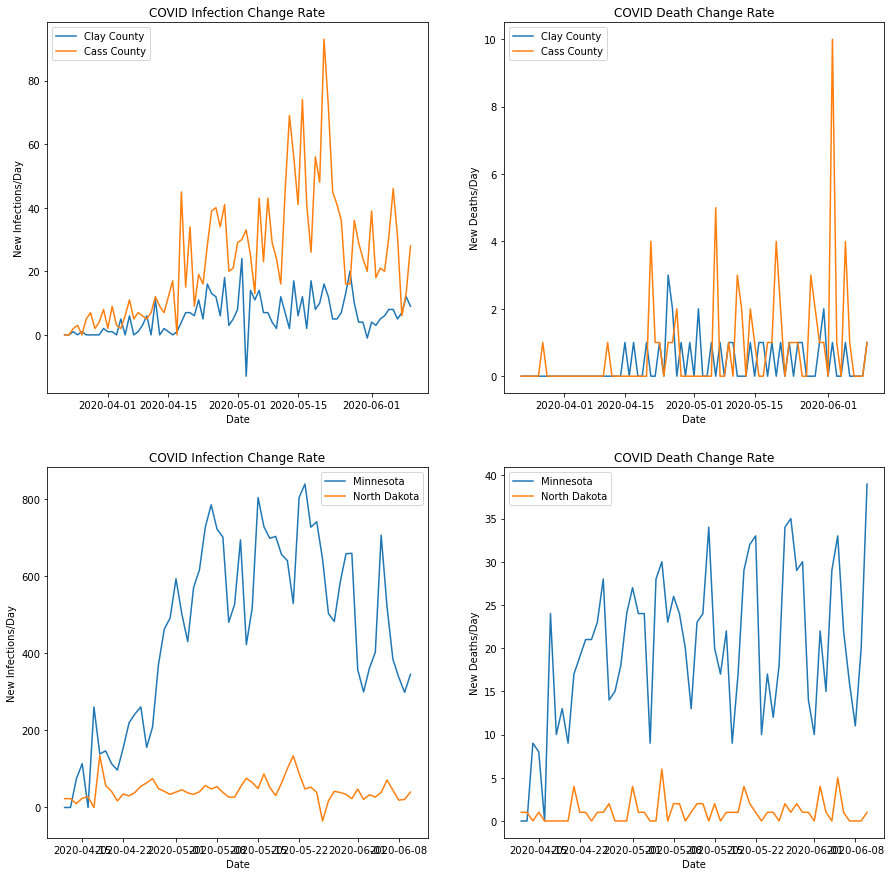

In [8]:
# Show demonstrations of plotting this data here by producing plots of data for Cass and Clay counties and North Dakota and Minnesota

#
# I will pull the data to plot into numpy arrays (notice I have to use [0] because it comes out at list of lists even for single row)
#

# County-level data for plotting
dates_cty = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['Dates'].to_list()[0], dtype='datetime64')
clay_ddeaths = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['dDeaths'].to_list()[0])
cass_ddeaths = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['dDeaths'].to_list()[0])
clay_dconfirmed = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['dConfirmed'].to_list()[0])
cass_dconfirmed = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['dConfirmed'].to_list()[0])

# State-level data for plotting
dates_state = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['Dates'].to_list()[0], dtype='datetime64')
MN_ddeaths = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['dDeaths'].to_list()[0])
ND_ddeaths = np.array(combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['dDeaths'].to_list()[0])
MN_dconfirmed = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['dConfirmed'].to_list()[0])
ND_dconfirmed = np.array(combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['dConfirmed'].to_list()[0])

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Plot up the deriviates in the infection and death rates for counties
this_axs = axs[0, 0]  # row 0, column 0
this_axs.plot(dates_cty, clay_dconfirmed, label='Clay County')
this_axs.plot(dates_cty, cass_dconfirmed, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("New Infections/Day")
title = this_axs.set_title("COVID Infection Change Rate")

this_axs = axs[0, 1]  # row 0, column 1
this_axs.plot(dates_cty, clay_ddeaths, label='Clay County')
this_axs.plot(dates_cty, cass_ddeaths, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("New Deaths/Day")
title = this_axs.set_title("COVID Death Change Rate")

# Plot up the deriviates in the infection and death rates for states
this_axs = axs[1, 0]  # row 1, column 0
this_axs.plot(dates_state, MN_dconfirmed, label='Minnesota')
this_axs.plot(dates_state, ND_dconfirmed, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("New Infections/Day")
title = this_axs.set_title("COVID Infection Change Rate")

this_axs = axs[1, 1]  # row 1, column 1
this_axs.plot(dates_state, MN_ddeaths, label='Minnesota')
this_axs.plot(dates_state, ND_ddeaths, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("New Deaths/Day")
title = this_axs.set_title("COVID Death Change Rate")

## Google Mobility Data (FIPS cross-identification performed)

This data is described at https://www.google.com/covid19/mobility/ and can be downloaded in a single monolithic CSV file at https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv

> The data shows how visitors to (or time spent in) categorized places change compared to our baseline days. A baseline day represents a normal value for that day of the week. The baseline day is the median value from the 5‑week period Jan 3 – Feb 6, 2020.

> For each region-category, the baseline isn’t a single value—it’s 7 individual values. The same number of visitors on 2 different days of the week, result in different percentage changes. So, we recommend the following:
1. Don’t infer that larger changes mean more visitors or smaller changes mean less visitors.
2. Avoid comparing day-to-day changes. Especially weekends with weekdays. (https://support.google.com/covid19-mobility/answer/9824897?hl=en&ref_topic=9822927)

> Note, *Parks* typically means official national parks and not the general outdoors found in rural areas.

Also, I'll note that aggregated national data appears to be available by setting `sub_region_1` **and** `sub_region_2` to `NaN` and state-level data by setting only `sub_region_2` to `NaN`.

**Note to Developers:** Check the `date` column in the reduced data to see if it is a real match or just a marker for a non-match.  Furthermore be away Google has a lot of blank (`NaN`) entries in a lot of columns and variable numbers of entries for each county/state.


**Suggested Citation**: Google LLC "Google COVID-19 Community Mobility Reports". https://www.google.com/covid19/mobility/ Accessed: `<Date>.`

In [9]:
# Retrieve the Google Mobility dataframes
(goog_mobility_cnty_df, goog_mobility_states_df) = COVIDdata.retrieve_goog_mobility_data(cnty_pop_df, state_pop_df)

# Export the google mobility data to CSV files
print("Exporting Google mobility data")
    
goog_mobility_cnty_fname = data_dir + "goog_mobility_cnty.csv"
print(" - Google county level mobility data exported to ", goog_mobility_cnty_fname)
goog_mobility_cnty_df.to_csv(goog_mobility_cnty_fname, index=False)

goog_mobility_states_fname = data_dir + "goog_mobility_state.csv"
print(" - Google state level mobility data exported to ", goog_mobility_states_fname)
goog_mobility_states_df.to_csv(goog_mobility_states_fname, index=False)

#
# Save the same data to pickle files
#
goog_mobility_cnty_fname = data_dir + "goog_mobility_cnty.p"
print(" - Google county level mobility data also exported to ", goog_mobility_cnty_fname)
with open(goog_mobility_cnty_fname, 'wb') as pickle_file:
    pickle.dump(goog_mobility_cnty_df, pickle_file)
    pickle_file.close()

goog_mobility_states_fname = data_dir + "goog_mobility_state.p"
print(" - Google state level mobility data also exported to ", goog_mobility_states_fname)
with open(goog_mobility_states_fname, 'wb') as pickle_file:
    pickle.dump(goog_mobility_states_df, pickle_file)
    pickle_file.close()

/Users/juan/miniconda3/envs/astro37/lib/python3.7/site-packages/pandas/core/indexes/base.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = op(self.values, np.asarray(other))


Exporting Google mobility data
 - Google county level mobility data exported to  our_data/goog_mobility_cnty.csv
 - Google state level mobility data exported to  our_data/goog_mobility_state.csv
 - Google county level mobility data also exported to  our_data/goog_mobility_cnty.p
 - Google state level mobility data also exported to  our_data/goog_mobility_state.p


## Apple Mobility Data  (FIPS cross-identification performed)

This data is described at https://www.apple.com/covid19/mobility.

**About this Data (copied from Apple's site)**: The CSV file on this site show a relative volume of directions requests per country/region, sub-region or city compared to a baseline volume on January 13th, 2020. We define our day as midnight-to-midnight, Pacific time. Cities are defined as the greater metropolitan area and their geographic boundaries remain constant across the data set. In many countries/regions, sub-regions, and cities, relative volume has increased since January 13th, consistent with normal, seasonal usage of Apple Maps. Day of week effects are important to normalize as you use this data. Data that is sent from users’ devices to the Maps service is associated with random, rotating identifiers so Apple doesn’t have a profile of individual movements and searches. Apple Maps has no demographic information about our users, so we can’t make any statements about the representativeness of usage against the overall population.

Apple tracks three kinds of Apple Maps routing requests: Driving, Walking, Transit.  But the only data available at the state and county level is the Driving data.

**Developer Notes**: While Apple has fewer blank (`NaN`) entries when a county was included (versus Google data), Apple's mobility data only exists for 2090 out of 3142 counties in the US. Counties with no published data are in this dataframe as `NaN` for both dates and driving mobility information.


In [10]:
# Retrieve the Apple Mobility dataframes
(aapl_mobility_cnty_df, aapl_mobility_states_df) = COVIDdata.retrieve_aapl_mobility_data(cnty_pop_df, state_pop_df)

# Notice only driving information is available at the county level here
print("APPLE MOBILITY DATA IN aapl_mobility_cnty_df() FOR CLAY COUNTY")
aapl_mobility_clay = aapl_mobility_cnty_df[(aapl_mobility_cnty_df['county'] == 'Clay County') & (aapl_mobility_cnty_df['state'] == 'Minnesota')]
print(aapl_mobility_clay)
    
# Export the Apple mobility data to CSV files
print("\nExporting Apple mobility data")
    
aapl_mobility_cnty_fname = data_dir + "aapl_mobility_cnty.csv"
print(" - Apple county level mobility data exported to ", aapl_mobility_cnty_fname)
aapl_mobility_cnty_df.to_csv(aapl_mobility_cnty_fname, index=False)

aapl_mobility_states_fname = data_dir + "aapl_mobility_state.csv"
print(" - Apple state level mobility data exported to ", aapl_mobility_states_fname)
aapl_mobility_states_df.to_csv(aapl_mobility_states_fname, index=False)

#
# Save the same data to pickle files
#
aapl_mobility_cnty_fname = data_dir + "aapl_mobility_cnty.p"
print(" - Apple county level mobility data also exported to ", aapl_mobility_cnty_fname)
with open(aapl_mobility_cnty_fname, 'wb') as pickle_file:
    pickle.dump(aapl_mobility_cnty_df, pickle_file)
    pickle_file.close()

aapl_mobility_states_fname = data_dir + "aapl_mobility_state.p"
print(" - Apple state level mobility data also exported to ", aapl_mobility_states_fname)
with open(aapl_mobility_states_fname, 'wb') as pickle_file:
    pickle.dump(aapl_mobility_states_df, pickle_file)
    pickle_file.close()

APPLE MOBILITY DATA IN aapl_mobility_cnty_df() FOR CLAY COUNTY
       FIPS      state       county  \
1327  27027  Minnesota  Clay County   

                                                  dates  \
1327  [2020-01-13, 2020-01-14, 2020-01-15, 2020-01-1...   

                                       driving_mobility  
1327  [100.0, 92.08, 85.04, 105.88, 83.43, 67.13, 93...  

Exporting Apple mobility data
 - Apple county level mobility data exported to  our_data/aapl_mobility_cnty.csv
 - Apple state level mobility data exported to  our_data/aapl_mobility_state.csv
 - Apple county level mobility data also exported to  our_data/aapl_mobility_cnty.p
 - Apple state level mobility data also exported to  our_data/aapl_mobility_state.p


## Institute for Health Metrics and Evaluation (IMHE) Data on Local Resources  (FIPS cross-identification performed)

There is Institute for Health Metrics and Evaluation data on local resources at http://www.healthdata.org/covid/data-downloads although data only has state level resolution. 

**Suggested Citation**: Institute for Health Metrics and Evaluation (IHME). COVID-19 Hospital Needs and Death Projections. Seattle, United States of America: Institute for Health Metrics and Evaluation (IHME), University of Washington, 2020.

**Note to Developers:** IMHE data has a few blank (`NaN`) entries for dates, presumably reflecting unknown values.  Also, some of the dates are from 2019, which suggests no known values.

In [11]:
# Retrieve IMHE data
(imhe_summary, imhe_hospitalizations) = COVIDdata.retrieve_imhe_data(cnty_pop_df, state_pop_df)

## Summary data includes numbers or dates for the following for each state
#             'peak_bed_day_mean', 'peak_bed_day_lower', 'peak_bed_day_upper': Mean/Lower/Upper Uncertainty peak bed use date
# 'peak_icu_bed_day_mean', 'peak_icu_bed_day_lower', 'peak_icu_bed_day_upper': Mean/Lower/Upper Uncertainty ICU bed use date
#          'peak_vent_day_mean', 'peak_vent_day_lower', 'peak_vent_day_upper': Mean/Lower/Upper Uncertainty Ventilator use date
#    'all_bed_capacity', 'icu_bed_capacity', 'all_bed_usage', 'icu_bed_usage': Number of beds/ICU beds/avg beds used/avg ICU beds used
#                          'travel_limit_start_date', 'travel_limit_end_date': Severe travel restrictions start/end dates
#                                'stay_home_start_date', 'stay_home_end_date': Stay at home order start/end dates
#                    'educational_fac_start_date', 'educational_fac_end_date': Educational facilities closure start/end dates
#      'any_gathering_restrict_start_date', 'any_gathering_restrict_end_date': Any gathering restrictions start/end dates
#                          'any_business_start_date', 'any_business_end_date': Any business closures start/end dates
#          'all_non-ess_business_start_date', 'all_non-ess_business_end_date': Non-essential businesses ordered to close start/end dates
#
# 'NaN' present for dates means it isn't known.

## Hospitalization data is time series date for the following projections by the IMHE:
#                             'allbed_mean', 'allbed_lower','allbed_upper': Predicted COVID beds needed with upper/lower bounds
#                            'ICUbed_mean', 'ICUbed_lower', 'ICUbed_upper': Predicted COVID ICU beds needed with upper/lower bounds
#                            'InvVen_mean', 'InvVen_lower', 'InvVen_upper': Predicted COVID ventilators needed with upper/lower bounds
#                            'deaths_mean', 'deaths_lower', 'deaths_upper': Predicted COVID daily deaths with upper/lower bounds
#                               'admis_mean', 'admis_lower', 'admis_upper': Predicted hospital admissions with upper/lower bounds
#                            'newICU_mean', 'newICU_lower', 'newICU_upper': Predicted new ICU admissions per day with upper/lower bounds
#                            'totdea_mean', 'totdea_lower', 'totdea_upper': Predicted COVID cumilative deaths with upper/lower bounds
# 'deaths_mean_smoothed', 'deaths_lower_smoothed', 'deaths_upper_smoothed': Smoothed version of predicted COVID daily deaths
# 'totdea_mean_smoothed', 'totdea_lower_smoothed', 'totdea_upper_smoothed': Smoothed version of cumilative COVID deaths
#                                   'total_tests_data_type', 'total_tests': observed/predicted tests and total number of tests
#                                                   'confirmed_infections': Observed confirmed infections only
#    'est_infections_mean', 'est_infections_lower', 'est_infections_upper': Predicted estimated infections with upper/lower bounds
#
# 'NaN' present for dates means it isn't known.

# Write out CSV files to disk
imhe_summary_fname = data_dir + "imhe_summary.csv"
print(" - IMHE state level summary data exported to ", imhe_summary_fname)
imhe_summary.to_csv(imhe_summary_fname, index=False)

imhe_hospitalizations_fname = data_dir + "imhe_hospitalizations.csv"
print(" - IMHE hospitalization level summary data exported to ", imhe_summary_fname)
imhe_hospitalizations.to_csv(imhe_hospitalizations_fname, index=False)

#
# Save the same data to pickle files
#
imhe_summary_fname = data_dir + "imhe_summary.p"
print(" - IMHE state level summary data also exported to ", imhe_summary_fname)
with open(imhe_summary_fname, 'wb') as pickle_file:
    pickle.dump(imhe_summary, pickle_file)
    pickle_file.close()

imhe_hospitalizations_fname = data_dir + "imhe_hospitalizations.p"
print(" - IMHE hospitalization level summary data also exported to ", imhe_summary_fname)
with open(imhe_hospitalizations_fname, 'wb') as pickle_file:
    pickle.dump(imhe_hospitalizations, pickle_file)
    pickle_file.close()

# Present summary data for local area
print("\nIMHE SUMMARY DATA IN imhe_summary() FOR MN and ND")
imhe_summary_local = imhe_summary[(imhe_summary.FIPS == MNFIPS) | (imhe_summary.FIPS == NDFIPS) ]
print(imhe_summary_local)

# Present hospitalizations data for local area
print("\nIMHE SUMMARY DATA IN imhe_hospitalizations() FOR MN and ND")
imhe_hospitalizations_local = imhe_hospitalizations[(imhe_hospitalizations.FIPS == MNFIPS) | (imhe_hospitalizations.FIPS == NDFIPS) ]
print(imhe_hospitalizations_local)

 - IMHE state level summary data exported to  our_data/imhe_summary.csv
 - IMHE hospitalization level summary data exported to  our_data/imhe_summary.csv
 - IMHE state level summary data also exported to  our_data/imhe_summary.p
 - IMHE hospitalization level summary data also exported to  our_data/imhe_summary.p

IMHE SUMMARY DATA IN imhe_summary() FOR MN and ND
    FIPS         state peak_bed_day_mean peak_bed_day_lower  \
23    27     Minnesota        2020-05-22         2020-05-05   
34    38  North Dakota        2020-05-10         2020-05-08   

   peak_bed_day_upper peak_icu_bed_day_mean peak_icu_bed_day_lower  \
23         2020-09-26            2020-05-22             2020-05-08   
34         2020-09-06            2020-05-10             2020-05-08   

   peak_icu_bed_day_upper peak_vent_day_mean peak_vent_day_lower  ...  \
23             2020-09-26         2020-05-22          2020-05-07  ...   
34             2020-09-10         2020-05-10          2020-05-08  ...   

   stay_home_s

## NY Times Data on Probable Deaths/Cases (FIPS Present, NOT CURRENTLY USED FOR PROJECT)

The NY Times has assembled data on COVID in a GitHub repository at https://github.com/nytimes/covid-19-data.  I have not examined that data yet, but it may well be interesting.

Note their statement requiring credit:

> In light of the current public health emergency, The New York Times Company is
providing this database under the following free-of-cost, perpetual,
non-exclusive license. Anyone may copy, distribute, and display the database, or
any part thereof, and make derivative works based on it, provided  (a) any such
use is for non-commercial purposes only and (b) credit is given to The New York
Times in any public display of the database, in any publication derived in part
or in full from the database, and in any other public use of the data contained
in or derived from the database.

Data is available at county, state, and national levels for live numbers (current cases/deaths as well as probable cases/deaths, updated daily).  That said, at least locally I don't think Probable cases are really making a difference.


In [12]:
##
## Retrieve the NYT datafiles to see what is there that might be of interest
##

# NYT COVID data GIT repo
NYT_gitrepo = "https://github.com/nytimes/covid-19-data.git"

# Local repo location for the NYT Datafiles
NYTdata_dir = "NYT_Data/"

# Check if the local git repository directory exists, if not, create it and clone the repo to it
if not os.path.exists(NYTdata_dir):
    os.makedirs(NYTdata_dir)
    git.Repo.clone_from(NYT_gitrepo, NYTdata_dir)
    
g = git.cmd.Git(NYTdata_dir)
# We should check status to see everything is good eventually, 
# for now, I am using this to hide the status message from GitPython module
status = g.pull()  

# Grab the live data files
live_county_csv = NYTdata_dir+"live/us-counties.csv"
live_state_csv = NYTdata_dir+"live/us-states.csv"
live_us_csv = NYTdata_dir+"live/us.csv"

# Create pandas dataframes containing the daily data from the CSV files (contains number of confirmed/deaths/recovered on that date)
live_county_df = pd.read_csv(live_county_csv)   # County totals
live_state_df = pd.read_csv(live_state_csv)    # State totals
live_us_df = pd.read_csv(live_us_csv)       # National totals

# Print county data to screen
print("LOCAL COUNTY DATA IN live_county_df() DATAFRAME")
print(live_county_df[ (live_county_df['fips'] == ClayFIPS) | (live_county_df['fips'] == CassFIPS) ])

# Print state level data to screen
print("\nLOCAL STATE DATA IN live_state_df() DATAFRAME")
print(live_state_df[ (live_state_df['fips'] == MNFIPS) | (live_state_df['fips'] == NDFIPS) ])

# Print national data
print("\nNATIONAL DATA IN live_us_df() DATAFRAME")
print(live_us_df)

LOCAL COUNTY DATA IN live_county_df() DATAFRAME
            date county         state     fips  cases  deaths  \
1303  2020-06-11   Clay     Minnesota  27027.0    490    31.0   
1917  2020-06-11   Cass  North Dakota  38017.0   1958    61.0   

      confirmed_cases  confirmed_deaths  probable_cases  probable_deaths  
1303            490.0              31.0             NaN              NaN  
1917           1958.0              61.0             NaN              NaN  

LOCAL STATE DATA IN live_state_df() DATAFRAME
          date         state  fips  cases  deaths  confirmed_cases  \
24  2020-06-11     Minnesota    27  28900    1267          28869.0   
35  2020-06-11  North Dakota    38   2944      76           2941.0   

    confirmed_deaths  probable_cases  probable_deaths  
24            1236.0            31.0             31.0  
35              73.0             3.0              3.0  

NATIONAL DATA IN live_us_df() DATAFRAME
         date    cases  deaths  confirmed_cases  confirmed_death

In [13]:
# Mark the start of processing
end = time.perf_counter()

print(f"Entire process of executing this script took {end-start:0.2f} sec.")

Entire process of executing this script took 73.80 sec.
